<div class='alert alert-warning'>

# JupyterLite warning

If you are running the current notebook in JupyterLite, you may encounter some unexpected behavior.

The main difference is that imports take longer than usual, for example the first `import sklearn` can take up to 10-20s.

If you notice problems, feel free to open an [issue](https://github.com/probabl-ai/youtube-appendix/issues/new/choose) about it.
</div>

In [ ]:
%pip install skrub polars pyodide-http

import polars as pl
import pyodide_http
from skrub import MinHashEncoder

In [ ]:
from sklearn.datasets import fetch_20newsgroups

pyodide_http.patch_all()
X, y = fetch_20newsgroups(subset='train', return_X_y=True)

## HashingVectorizer

In [137]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(
    HashingVectorizer(ngram_range=(1, 1), analyzer="word"), 
    LogisticRegression()
)

grid = {
    "hashingvectorizer__n_features": [100, 200, 500, 1000, 2000, 5000, 10000]
}

cv = GridSearchCV(pipe, grid, n_jobs=-1).fit(X, y)

In [ ]:
import matplotlib

p = pl.DataFrame(cv.cv_results_).plot.line("param_hashingvectorizer__n_features", "mean_test_score")

In [145]:
p

alt.Chart(...)

In [140]:
cv.cv_results_["mean_test_score"].max()

0.7869898372816378

In [143]:
from sklearn.feature_extraction.text import CountVectorizer

pipe_cv = make_pipeline(
    CountVectorizer(ngram_range=(1, 1), analyzer="word"),
    LogisticRegression(max_iter=1000)
)

cv = GridSearchCV(pipe_cv, {}, n_jobs=-1).fit(X, y)

In [144]:
cv.cv_results_

{'mean_fit_time': array([152.79486814]),
 'std_fit_time': array([5.28290112]),
 'mean_score_time': array([0.35974722]),
 'std_score_time': array([0.08333041]),
 'params': [{}],
 'split0_test_score': array([0.87185152]),
 'split1_test_score': array([0.88024746]),
 'split2_test_score': array([0.87759611]),
 'split3_test_score': array([0.87980557]),
 'split4_test_score': array([0.88240495]),
 'mean_test_score': array([0.87838112]),
 'std_test_score': array([0.00360431]),
 'rank_test_score': array([1], dtype=int32)}

In [136]:
len(cv.best_estimator_.steps[0][1].vocabulary_)

130107

## MinHash

In [1]:
from skrub import MinHashEncoder
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=42125, return_X_y=True)

enc = MinHashEncoder(n_components=2)

In [2]:
import polars as pl

uniq_names = pl.DataFrame({"employee_position_title": X["employee_position_title"].unique()})["employee_position_title"]

In [3]:
X_plot = enc.fit_transform(uniq_names)

In [4]:
X_plot.head()

employee_position_title_0,employee_position_title_1
f32,f32
-2.1265e9,-2.1434e9
-2.0988e9,-2.1105e9
-2.0854e9,-2.0863e9
-2.1102e9,-2.0663e9
-2.1353e9,-2.1432e9


In [5]:
def encode(string): 
    dataf = pl.DataFrame({"employee_position_title": [string]})
    return enc.transform(dataf["employee_position_title"])

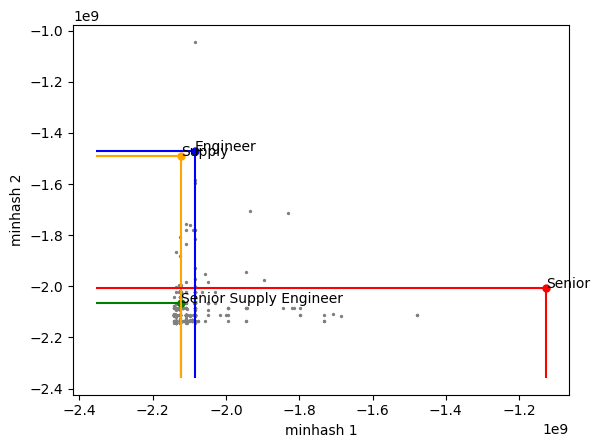

In [6]:
import matplotlib.pylab as plt
plt.scatter(X_plot["employee_position_title_0"], X_plot["employee_position_title_1"], s=2, color='gray')
plt.xlabel("minhash 1")
plt.ylabel("minhash 2")
# plt.xlim(None, -1.977e09)
# plt.ylim(None, -1.477e09)

combos = [
    ("Senior Supply Engineer", "green"),
    ("Supply", "orange"),
    ("Senior", "red"),
    ("Engineer", "blue"),
]
for title, color in combos:
    x = encode(title)
    plt.scatter(x["employee_position_title_0"], x["employee_position_title_1"], s=25, color=color)
    plt.vlines(x["employee_position_title_0"], 
               X_plot["employee_position_title_1"].min() * 1.1, 
               x["employee_position_title_1"], 
               color=color)
    plt.hlines(x["employee_position_title_1"], 
               X_plot["employee_position_title_0"].min() * 1.1, 
               x["employee_position_title_0"], 
               color=color)
    plt.text(x["employee_position_title_0"][0], 
             x["employee_position_title_1"][0],
             title)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

pipe_minhash = Pipeline([
    ("encoder", MinHashEncoder(n_components=100)),
    ("estimator", HistGradientBoostingRegressor())
])

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipe_minhash, X["employee_position_title"], y).mean()

np.float64(0.8090042056038712)